# Introduction

* Lung segmentation from chest X-ray datasets involves the process of identifying and delineating the boundaries of the lungs in medical images. It plays a crucial role in various applications such as computer-aided diagnosis, lung disease detection, and quantitative analysis of lung abnormalities.

* The goal of lung segmentation is to accurately separate the lung regions from the rest of the chest X-ray image, including other structures like ribs, mediastinum, and diaphragm. This segmentation process enables subsequent analysis and measurements to be performed on the lung regions alone, facilitating the detection and characterization of lung diseases.

* The task of lung segmentation is challenging due to several factors. Chest X-ray images can exhibit variations in image quality, patient positioning, and anatomical differences among individuals. Additionally, the presence of artifacts like medical devices and ribs can obscure the clear visibility of lung boundaries, making accurate segmentation difficult and to tackle this challenge, various techniques and algorithms have been developed. Traditional image processing methods, such as thresholding, edge detection, and region growing, have been used for lung segmentation. However, more recently, deep learning techniques have shown promising results. Convolutional neural networks (CNNs) and specifically designed architectures like U-Net have been employed to perform pixel-level segmentation of the lungs.

<center> <img   width="900"  src="https://cell.missouri.edu/media/publications/Screen_Shot_2013-12-29_at_10.52.46_AM.png" alt="Alternative text" /> </center>
<br></br>


In [2]:
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

# Set the path to the directory containing the chest X-ray images
image_path = os.path.join("../input/data/Lung Segmentation/CXR_png")

# Set the path to the directory containing the lung segmentation masks
mask_path = os.path.join("../input/data/Lung Segmentation/","masks/")


In [3]:
# Retrieve the list of image and mask filenames
images = os.listdir(image_path)
mask = os.listdir(mask_path)

# Remove the file extension from each mask filename
mask = [fName.split(".png")[0] for fName in mask]

# Remove the "_mask" suffix from each mask filename to obtain corresponding image filenames
image_file_name = [fName.split("_mask")[0] for fName in mask]

## these operations ensure that each mask file is associated with the correct corresponding image file by
## extracting the base names of the files and removing any unnecessary file extensions or suffixes.

In [4]:
## filter() function is used to create a new list, check, by filtering the elements from the mask list based on the condition specified in the lambda function.
## The lambda function checks if the string "mask" is present in each filename. The resulting list will only contain the modified mask filenames. T

check = list(filter(lambda x: "mask" in x, mask))
print("Total masks that have modified names:", len(check))

Total masks that have modified names: 566


Earlier I was going to train on the Shenzhen dataset while perform prediction on the Montgomery dataset. However, the nature of the data was diffrent in both the set. The images from Shenzhen dataset had smaller lung-to-image ratio as compared to the Montgomery dataset.

Thus, I am loading the two dataset seperately which I combined once I got to know about the disparity.

In [5]:
# Get the set of filenames that exist in both the image and mask directories
testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = check

def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    
    if flag == "test":
        for i in tqdm(testing_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]
            
            im_array.append(im)
            mask_array.append(mask)
        
        return im_array,mask_array
    
    if flag == "train":
        for i in tqdm(training_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

def getData(X_shape, flag="test"):
    """
    Function to retrieve image and mask data for testing or training.

    Args:
    - X_shape: int, the desired shape for resizing the images and masks
    - flag: str, indicates whether to retrieve data for testing or training
    
    Returns:
    - im_array: list, contains the resized image data
    - mask_array: list, contains the resized mask data
    """

    im_array = []
    mask_array = []

    if flag == "test":
        for i in tqdm(testing_files):
            # Read and resize the image and mask
            im = cv2.resize(cv2.imread(os.path.join(image_path, i)), (X_shape, X_shape))[:, :, 0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path, i)), (X_shape, X_shape))[:, :, 0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array, mask_array

    if flag == "train":
        for i in tqdm(training_files):
            # Get the corresponding image filename by removing the "_mask" suffix and appending ".png"
            image_filename = i.split("_mask")[0] + ".png"
            
            # Read and resize the image and mask
            im = cv2.resize(cv2.imread(os.path.join(image_path, image_filename)), (X_shape, X_shape))[:, :, 0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path, i + ".png")), (X_shape, X_shape))[:, :, 0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array, mask_array

In [6]:
import seaborn as sns
# Perform sanity check
def plotMask(X, y):
    sample = []
    num_samples = min(6, len(X), len(y))  # Determine the number of samples to plot
    
    # Combine X and y for visualization
    for i in range(num_samples):
        left = X[i]
        right = y[i]
        combined = np.hstack((left, right))
        sample.append(combined)
        
    # Plot the combined images
    for i in range(0, num_samples, 3):
        plt.figure(figsize=(25, 10))
        
        # Plot the first image
        plt.subplot(2, 3, 1+i)
        plt.imshow(sample[i])
        plt.title("Image")
        
        # Plot the corresponding mask
        plt.subplot(2, 3, 2+i)
        plt.imshow(sample[i+1])
        plt.title("Mask")
        
        # Plot the overlay of the image and mask
        plt.subplot(2, 3, 3+i)
        plt.imshow(sample[i+2])
        plt.title("Overlay")
        
        plt.tight_layout()
        plt.show()


In [7]:
# Load training and testing data
dim = 256*2
X_train,y_train = getData(dim,flag="train")
X_test, y_test = getData(dim)

100%|██████████| 138/138 [01:02<00:00,  2.21it/s]


training set


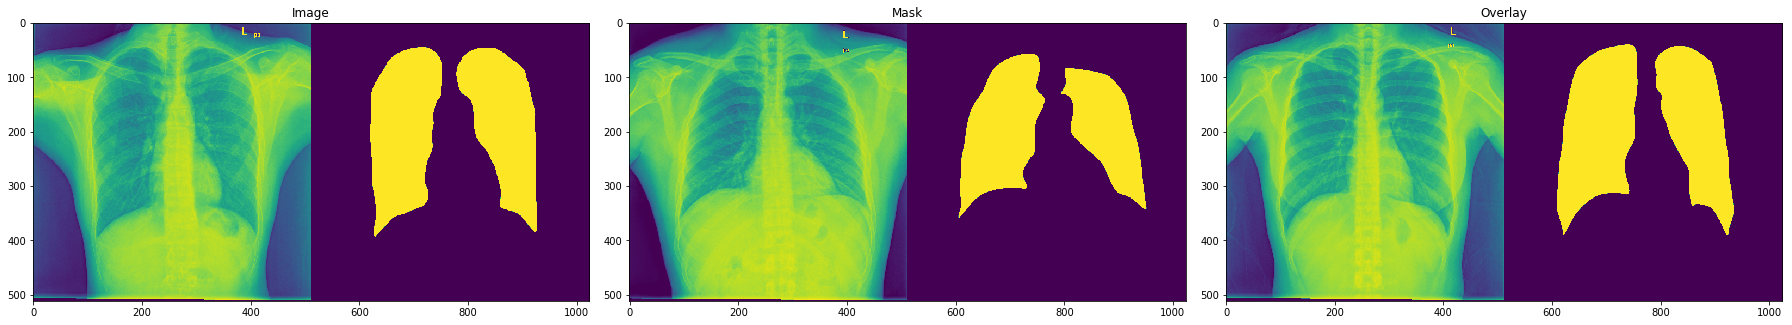

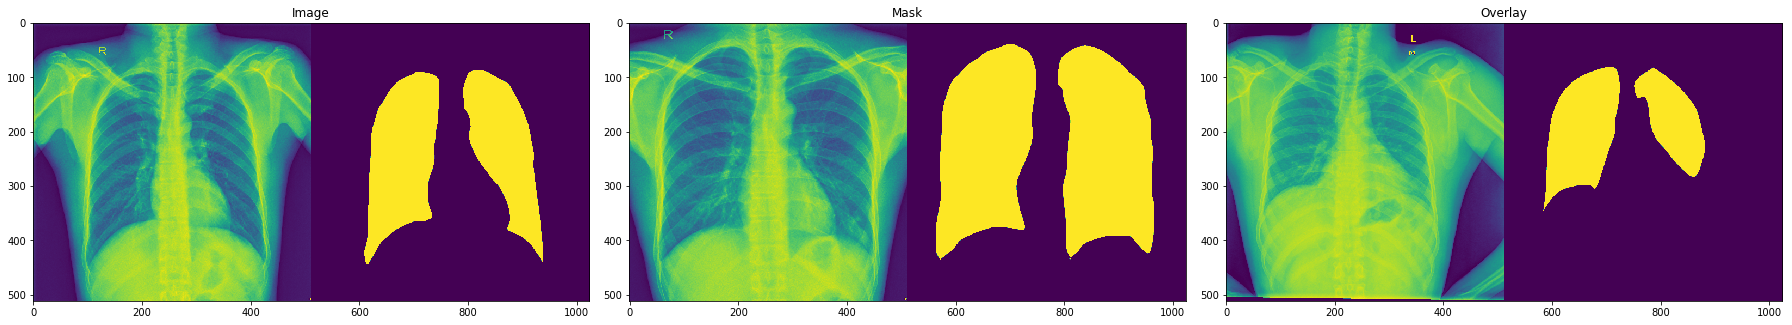

testing set


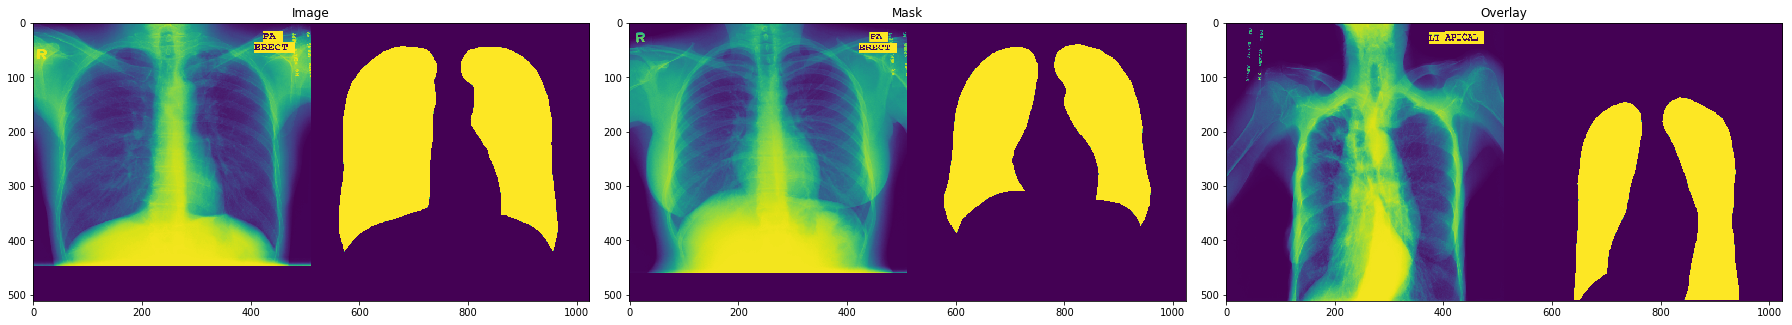

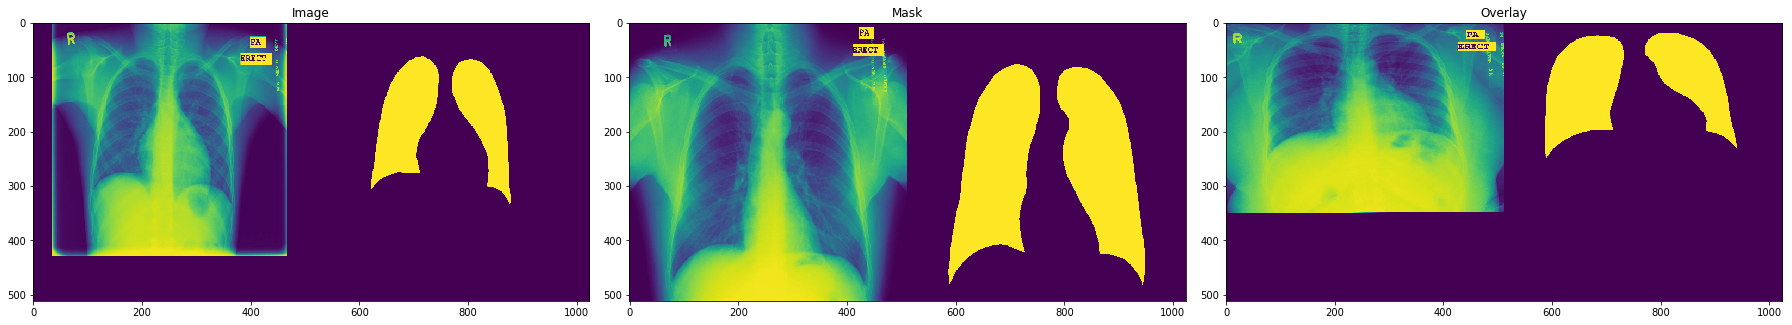

In [8]:
print("training set")
plotMask(X_train,y_train)
print("testing set")
plotMask(X_test,y_test)

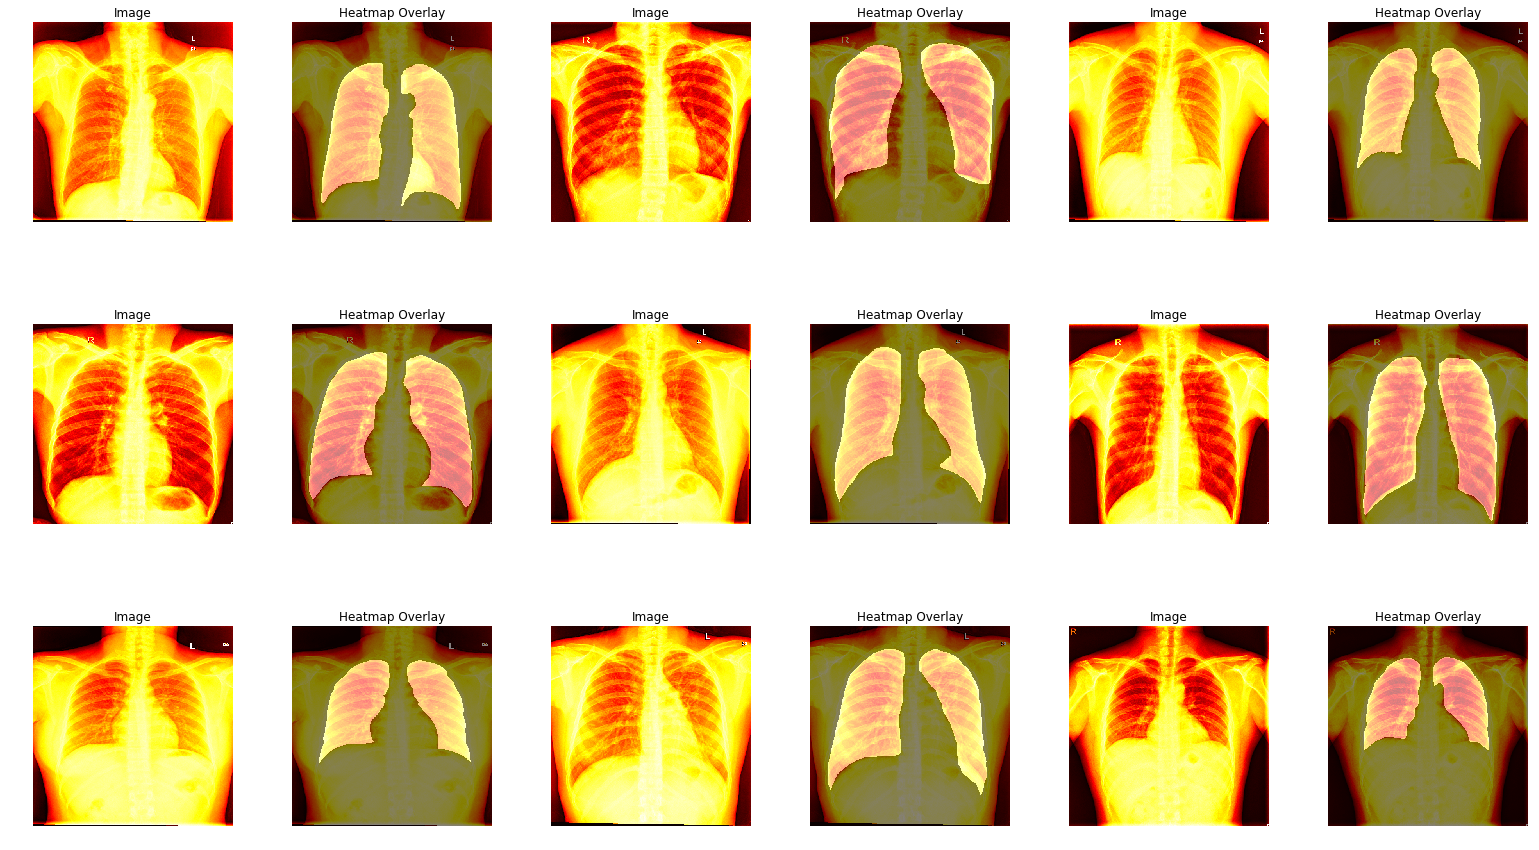

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Define the number of examples to visualize
num_examples = 9

fig, axes = plt.subplots(num_examples // 3, 6, figsize=(22, 13))

for i in range(num_examples):
    # Generate a random index
    index = np.random.randint(len(X_train))
    
    # Get the image and corresponding mask
    image = X_train[index]
    mask = y_train[index]
    
    # Generate the heatmap
    heatmap = np.zeros_like(image)
    heatmap[mask > 0] = 1
    
    # Compute row and column indices
    row_idx = i // 3
    col_idx = (i % 3) * 2
    
    # Display the image with hot colormap
    im = axes[row_idx, col_idx].imshow(image, cmap='hot')
    axes[row_idx, col_idx].set_title('Image')
    axes[row_idx, col_idx].axis('off')
    
    # Display the heatmap overlay with hot colormap
    overlay = axes[row_idx, col_idx + 1].imshow(image, cmap='hot')
    axes[row_idx, col_idx + 1].imshow(heatmap, cmap='hot', alpha=0.5)
    axes[row_idx, col_idx + 1].set_title('Heatmap Overlay')
    axes[row_idx, col_idx + 1].axis('off')


plt.tight_layout(pad=3.0)
plt.show()


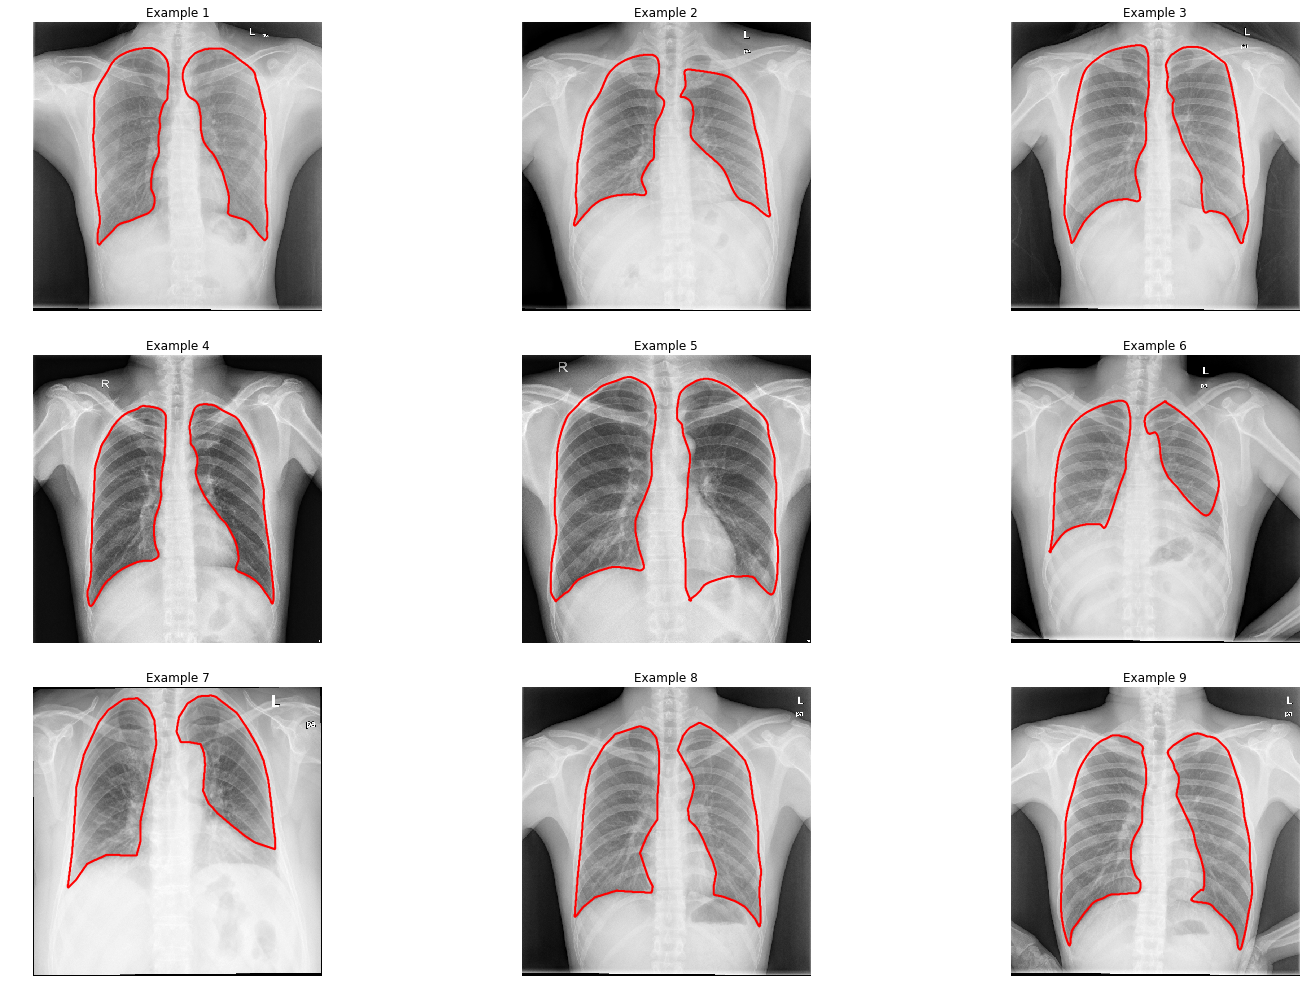

In [10]:
# Define the number of examples to visualize
num_examples = 9

fig, axes = plt.subplots(3, 3, figsize=(22, 14))

for i in range(num_examples):
    # Get the image and corresponding mask
    image = X_train[i]
    mask = y_train[i]
    
    # Plot the image with overlaid contours
    ax = axes[i // 3, i % 3]
    ax.imshow(image, cmap='gray')
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    ax.contour(mask, levels=[0.5], colors='red', linewidths=2)
    ax.set_title(f'Example {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()


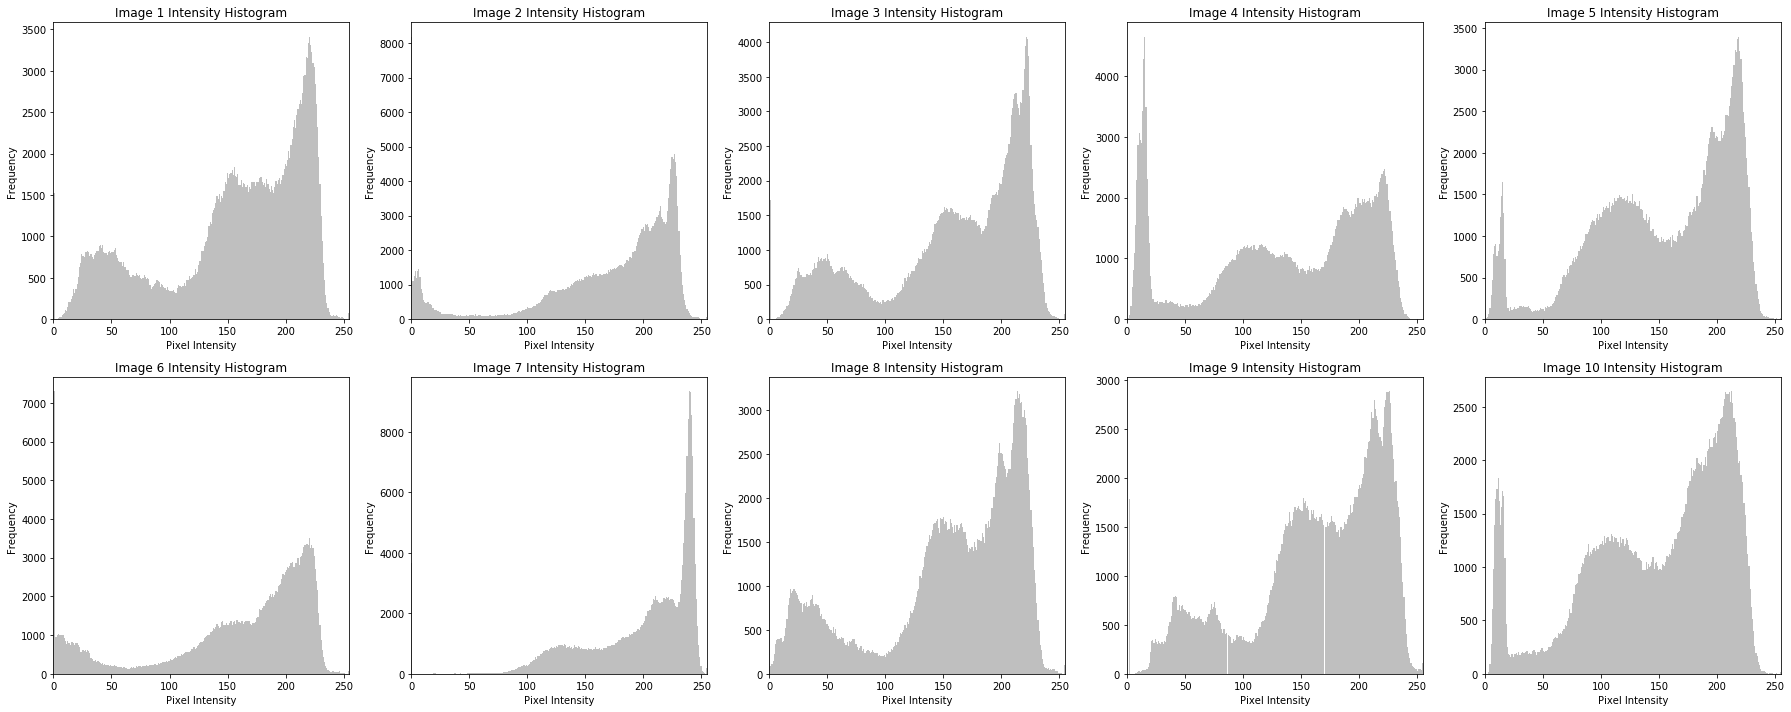

In [11]:
# Plot intensity histograms for images
plt.figure(figsize=(25, 10))
num_images = 10
num_bins = 256

for i in range(num_images):
    plt.subplot(2, 5, i+1)
    plt.hist(X_train[i].flatten(), bins=num_bins, color='gray', alpha=0.5)
    plt.title(f'Image {i+1} Intensity Histogram')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.xlim([0, 255])  # Set the x-axis limits

    # Add additional details
    image_min = np.min(X_train[i])
    image_max = np.max(X_train[i])
    image_mean = np.mean(X_train[i])
    image_std = np.std(X_train[i])

plt.tight_layout()
plt.show()

In [12]:
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train,X_test),axis=0)
mask  = np.concatenate((y_train,y_test),axis=0)

## U-Net Architecture
U-Net is an extension of FCN where it results in accurate segmentations even though the dataset is relatively small and Fully Connected Network (FCN): A FCN is basically a CNN where the dense/fully-connected layers are replaced with a convolutional layer with large receptive field (area of the image the CNN is looking at or it is also called as the kernel size) so that we get a high resolution image. 
<center> <img   width="1000"  src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*nbLpHkngf6JYHBfHvSE5oQ.jpeg" alt="Alternative text" /> </center>
<br></br>
        Here, the encoder network can be called as a contraction path and the decoder network can be called as a expansion path.<br></br>
<center> <img   width="500"  src="https://miro.medium.com/v2/resize:fit:786/format:webp/1*dYbiGpoojsAkVYeUMyiLsA.jpeg" alt="Alternative text" /> </center>
<br></br>

* The difference between the contraction and the expansion layers is that the pooling operations in the contraction network are replaced by up sampling operation in the expansion network. Also the expansion network has more number of filters which result in high resolution layers and as Biomedical Imaging has very less number of images, the network should be highly invariant. That means it should focus more on what the features are rather than where the features are. U-Net is able to achieve this due to its u-shape, where in the features are merged together to give high resolution results.

* Starting from the first step where the 572x572x1 input image is passed through two 3x3 convolutional layers (padding=’valid’ and strides=1) and ReLU activation where the number of channels are increased. It is then sent through a 2x2 max-pooling layer where the image is down sampled. This process is then repeated multiple times till the size of the image becomes 28x28x1024. Now, instead of down sampling, it is sent through a 2x2 deconvolutional layer (or transpose convolution) with strides=2 and then, it is consecutively concatenated with a cropped version of the previous feature map and is sent through two 3x3 convolutional layers like in the contraction path. The above process is repeated (shown in the figure) till we get an image of size 388x388x64 where finally a 1x1 convolution layer is applied on it to result in a 388x388x2 sized output as there are 2 channels in the experiment.

* The third column in the dimension represents the number of channels which is effectively the number of classes present. So we can see that this architecture can be easily extended to multiple classes and when we talk about loss functions for segmentation tasks, through experimentation, dice loss and cross entropy loss are one of the best ways to go.


In [13]:
from keras.models import Model
from keras.layers import Input, Conv2D, UpSampling2D, concatenate, MaxPooling2D
from keras.optimizers import Adam

def dice_coef(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = UpSampling2D((2, 2))(conv5)
    up6 = concatenate([up6, conv4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D((2, 2))(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = UpSampling2D((2, 2))(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = UpSampling2D((2, 2))(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model



Using TensorFlow backend.


### Compile and train the Unet Model

To compile a U-Net model, you need to define the optimizer, loss function, and metrics to be used during training. Here's an example of how to compile a U-Net model with the dice_coef loss function and dice_coef metric , In this example, we use the Adam optimizer, which is a popular choice for deep learning tasks. The dice_coef_loss function is defined earlier, and it calculates the dice coefficient loss between the true and predicted masks. The dice_coef function is also defined earlier, and it calculates the dice coefficient metric to evaluate the model's performance during training.

In [14]:
model = unet(input_size=(512, 512, 1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

## Callbacks, Early Stopping and Reduced LR


In [15]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

/opt/conda/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/callbacks.py:1334: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


#### Train the model

I intially used a 60-40 train-test spit and got a loss of -0.97. However, the better way to do it is 80-10-10 train-test-validation spit. Below I am roughly doing the later.

In [23]:
from keras.optimizers import Adam 
from sklearn.model_selection import train_test_split


train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0, 
                                                            (mask>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 2018)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.1, 
                                                            random_state = 2018)

loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 4,
                  epochs = 5,
                  validation_data =(test_vol,test_seg) ,)

Train on 569 samples, validate on 64 samples
Epoch 1/5
569/569 [==============================] - 152s 267ms/step - loss: 0.0513 - dice_coef: 0.9487 - binary_accuracy: 0.9746 - val_loss: 0.0491 - val_dice_coef: 0.9509 - val_binary_accuracy: 0.9758
Epoch 2/5
569/569 [==============================] - 152s 266ms/step - loss: 0.0496 - dice_coef: 0.9504 - binary_accuracy: 0.9754 - val_loss: 0.0918 - val_dice_coef: 0.9082 - val_binary_accuracy: 0.9570
Epoch 3/5
569/569 [==============================] - 152s 267ms/step - loss: 0.0628 - dice_coef: 0.9372 - binary_accuracy: 0.9690 - val_loss: 0.0453 - val_dice_coef: 0.9547 - val_binary_accuracy: 0.9775
Epoch 4/5
569/569 [==============================] - 152s 267ms/step - loss: 0.0474 - dice_coef: 0.9526 - binary_accuracy: 0.9765 - val_loss: 0.0463 - val_dice_coef: 0.9537 - val_binary_accuracy: 0.9771
Epoch 5/5
569/569 [==============================] - 152s 267ms/step - loss: 0.0483 - dice_coef: 0.9517 - binary_accuracy: 0.9761 - val_loss: 0

## Plot the metric and evaluate 

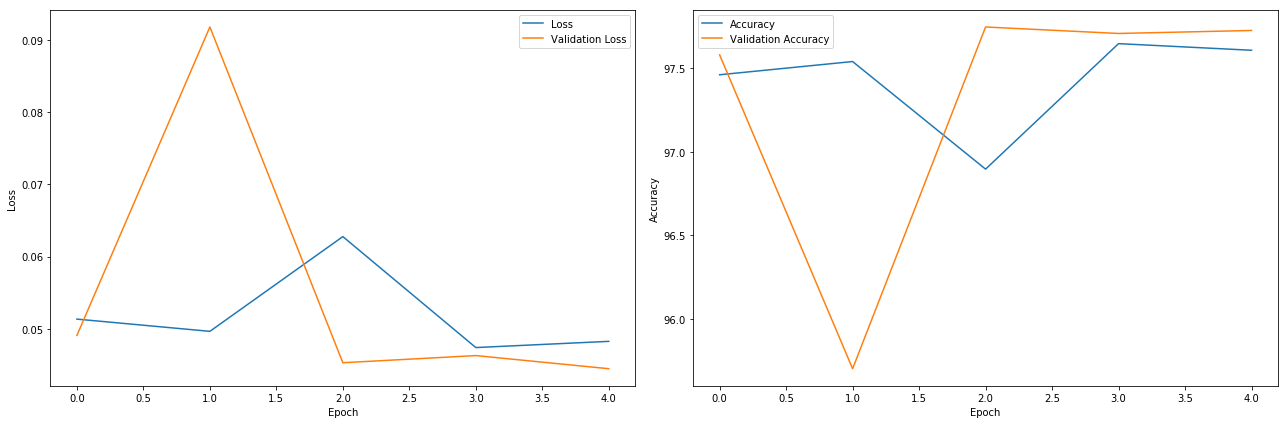

In [24]:
from sklearn.metrics import roc_curve, auc

# Plotting loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(loss_history.history['loss'], '-', label='Loss')
ax1.plot(loss_history.history['val_loss'], '-', label='Validation Loss')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(100 * np.array(loss_history.history['binary_accuracy']), '-', label='Accuracy')
ax2.plot(100 * np.array(loss_history.history['val_binary_accuracy']), '-', label='Validation Accuracy')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

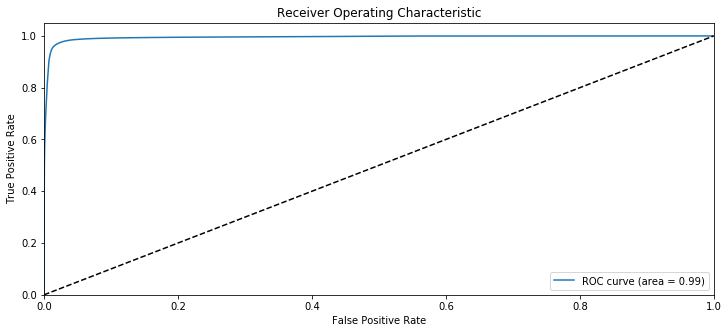

In [25]:
# Evaluating ROC curve
y_pred = model.predict(test_vol)
fpr, tpr, thresholds = roc_curve(test_seg.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Test the model

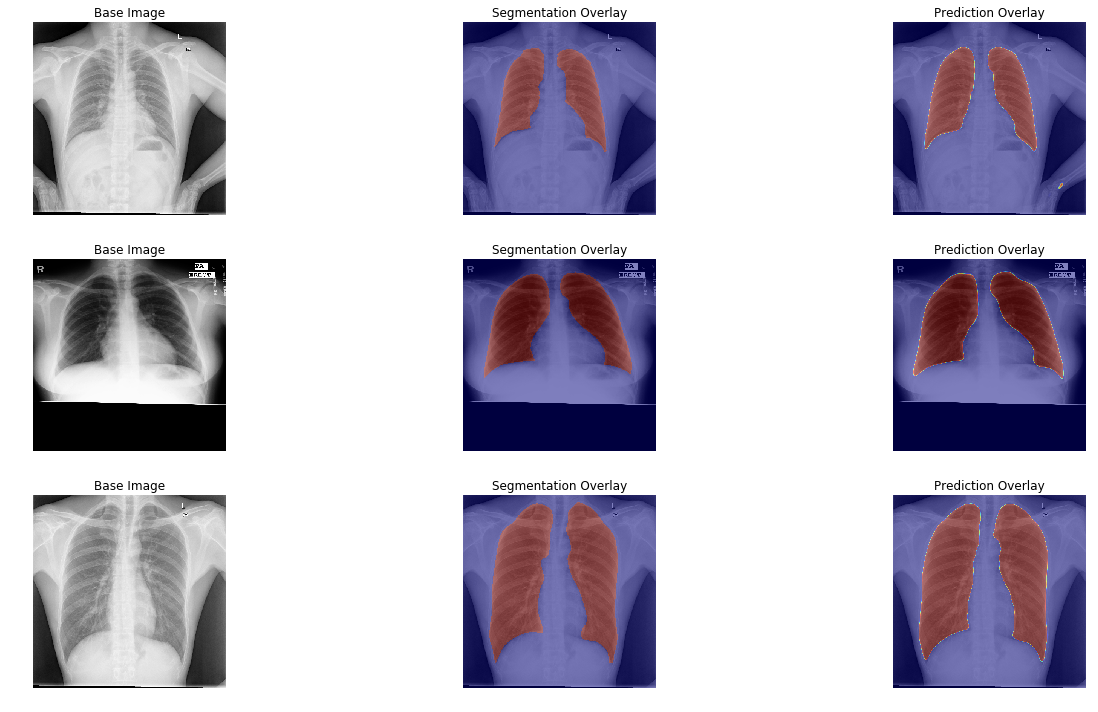

In [27]:
pred_candidates = np.random.randint(1, validation_vol.shape[0], 10)
preds = model.predict(validation_vol)

plt.figure(figsize=(20, 10))

for i in range(0, 9, 3):
    plt.subplot(3, 3, i + 1)
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]), cmap='gray')
    plt.title("Base Image")
    plt.axis('off')

    plt.subplot(3, 3, i + 2)
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]), cmap='gray')
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]), alpha=0.5, cmap='jet')
    plt.title("Segmentation Overlay")
    plt.axis('off')

    plt.subplot(3, 3, i + 3)
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]), cmap='gray')
    plt.imshow(np.squeeze(preds[pred_candidates[i]]), alpha=0.5, cmap='jet')
    plt.title("Prediction Overlay")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [28]:
# Save the model
model.save('unet_model2.h5')